# Following the walkthrough on http://soft-matter.github.io/trackpy/v0.4.2/tutorial/walkthrough.html

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import detrend

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline



# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import cv2
import imutils

import pims
import trackpy as tp

In [2]:
# number of frames
N = 950

# bitdepth
bitdepth = 16

# particle size (Large = 1, Medium/Small = 0)
Size = 0

# startframe number
startframe = 1


m = 7 #number of row in start calibration grid
n = 9 #number of columns in start calibration grid


# filename calibration file at the start
path = 'C:/Users/s131431/Documents/Thesis/Opnames/2021-03-08/start_calibration.tiff'

In [3]:



# If image has bitdepth 8 or it has sharp contrasts making grayscale values obsolete
if bitdepth == 8:
    image = cv2.imread(path,cv2.CV_8UC1) * 16
# 
elif bitdepth == 16:
    image = cv2.imread(path,cv2.CV_16UC1)


# Fixed thresholding
meanvalue = int(np.mean(image))
thresholdvalue = meanvalue/1.5
binaryImage = cv2.threshold(image,thresholdvalue,255,cv2.THRESH_BINARY_INV)[1]


# Define a course kernel
kernelClosed = np.ones((7,7),np.uint8)
kernelOpen   = np.ones((5,5),np.uint8)

# Reduce noise inside particles
binaryImageClosed = cv2.morphologyEx(binaryImage, cv2.MORPH_CLOSE, kernelClosed)


# Reduce noise outside particles
binaryImageOpened = cv2.morphologyEx(binaryImageClosed, cv2.MORPH_OPEN, kernelOpen)
markers = cv2.connectedComponents(np.uint8(binaryImageOpened))[1]
Nmarkers = len(np.unique(markers))
Ndots = int(n*m)
maximumSize = 80
minimumSize = 30
xdots = np.empty(0,dtype=float)
ydots = np.empty(0,dtype=float)

for i in range(1,Nmarkers,1):
    idx = np.argwhere(markers==i)
    
    xSpread = np.max(idx[:,1])-np.min(idx[:,1])    
    ySpread = np.max(idx[:,0])-np.min(idx[:,0])
    
    if ((minimumSize < xSpread < maximumSize) and (minimumSize < ySpread < maximumSize)):
        xdots = np.append(xdots,np.mean(idx[:,1]))
        ydots = np.append(ydots,np.mean(idx[:,0]))
    

# Sort the dots
NRows = m
NColumns = n

for i in range(0,NRows,1):
    idx = np.argsort(xdots[i*NColumns:(i+1)*NColumns])
    
    xdots[i*NColumns:(i+1)*NColumns] = xdots[i*NColumns+idx]
    ydots[i*NColumns:(i+1)*NColumns] = ydots[i*NColumns+idx]
    

Z2 = (ydots[n-1]-ydots[0])/(xdots[n-1]-xdots[0])

phi = np.arctan(Z2)
phi = phi*180/np.pi

print(phi)

-1.2592181614472828


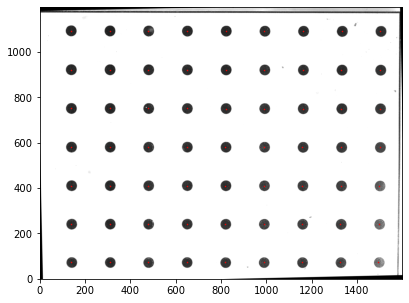

In [4]:


# Read image
image = cv2.imread(path)


Rotation = phi

# If image has bitdepth 8 or it has sharp contrasts making grayscale values obsolete
if bitdepth == 8:
    image = cv2.imread(path,cv2.CV_8UC1) * 16
# 
elif bitdepth == 16:
    image = cv2.imread(path,cv2.CV_16UC1)

# Show image
image = imutils.rotate(image, angle=Rotation)
#plt.figure()
#plt.imshow(image*1,origin='lower',cmap='gray')
#plt.show()


#plt.figure()
#plt.imshow(image*1,origin='lower',cmap='gray')
#plt.show()

# Fixed thresholding
meanvalue = int(np.mean(image))
thresholdvalue = meanvalue/1.5
binaryImage = cv2.threshold(image,thresholdvalue,255,cv2.THRESH_BINARY_INV)[1]

# Define a course kernel
kernelClosed = np.ones((7,7),np.uint8)
kernelOpen   = np.ones((5,5),np.uint8)

# Reduce noise inside particles
binaryImageClosed = cv2.morphologyEx(binaryImage, cv2.MORPH_CLOSE, kernelClosed)

# Reduce noise outside particles
binaryImageOpened = cv2.morphologyEx(binaryImageClosed, cv2.MORPH_OPEN, kernelOpen)
markers = cv2.connectedComponents(np.uint8(binaryImageOpened))[1]
Nmarkers = len(np.unique(markers))
Ndots = int(n*m)     #change for the number of dots on the calibration grid
maximumSize = 80
minimumSize = 30
xdots = np.empty(0,dtype=float)
ydots = np.empty(0,dtype=float)

for i in range(1,Nmarkers,1):
    idx = np.argwhere(markers==i)
    
    xSpread = np.max(idx[:,1])-np.min(idx[:,1])    
    ySpread = np.max(idx[:,0])-np.min(idx[:,0])
    
    if ((minimumSize < xSpread < maximumSize) and (minimumSize < ySpread < maximumSize)):
        xdots = np.append(xdots,np.mean(idx[:,1]))
        ydots = np.append(ydots,np.mean(idx[:,0]))
    
plt.figure()
plt.imshow(image,origin='lower',cmap='gray')
plt.plot(xdots,ydots,'r.',markersize=1)
plt.show()

# Sort the dots
NRows = m
NColumns = n

for i in range(0,NRows,1):
    idx = np.argsort(xdots[i*NColumns:(i+1)*NColumns])
    
    xdots[i*NColumns:(i+1)*NColumns] = xdots[i*NColumns+idx]
    ydots[i*NColumns:(i+1)*NColumns] = ydots[i*NColumns+idx]
    
# Positions of the dots in meters
distanceDots = 0.02 # meters
x = np.linspace(0,(NColumns-1)*distanceDots,NColumns)
y = np.linspace(0,(NRows-1)   *distanceDots,NRows)
xReal, yReal = np.meshgrid(x,y)

# We need these two arrays as input data sets for the least square fitting
Bx = xReal.flatten()
By = yReal.flatten()

# Positions of the dots in pixels
X = xdots*1 - xdots[0]
Y = ydots*1 - ydots[0]
A = np.array([X*0+1, X, Y, X**2, X**2*Y, X**2*Y**2, Y**2, X*Y**2, X*Y]).T

# Use linear least square fitting to find the coefficients that solve A*x=B
coeffx, _, _, _ = np.linalg.lstsq(A,Bx,rcond=None)
coeffy, _, _, _ = np.linalg.lstsq(A,By,rcond=None)

# This is the function we just used for fitting, but here explicit
def surface(x,y, a,b,c,d,e,f,g,h,i):
    return a + b*x + c*y + d*x**2 + e*x**2*y + f*x**2*y**2 + g*y**2 + h*x*y**2 + i*x*y

# This is the function to obtain the physical coordinates from the pixel coordinates
def conversion(X,Y):
    X1 = surface(X,Y,*coeffx)
    Y1 = surface(X,Y,*coeffy)
    return (X1,Y1)

def xconversion(X,Y):
    X1 = surface(X,Y,*coeffx)
    Y1 = surface(X,Y,*coeffy)
    return(X1)    
def yconversion(X,Y):
    X1 = surface(X,Y,*coeffx)
    Y1 = surface(X,Y,*coeffy)
    return(Y1)


## Step 1: Read the data

In [5]:
@pims.pipeline
def gray(image):
    return image#[:, :, 1]  # Take just the green channel

frames = pims.open('C:/Users/s131431/Documents/Thesis/Opnames/2021-03-08/curvelength700stroke45/curvelength700stroke45/z = 2/*.tiff')

In [6]:
print(frames)

<Frames>
Source: C:\Users\s131431\Documents\Thesis\Opnames\2021-03-08\curvelength700stroke45\curvelength700stroke45\z = 2\*.tiff
Length: 439 frames
Frame Shape: (1200, 1600)
Pixel Datatype: uint16


Frame([[77, 53, 47, ..., 52, 44, 56],
       [59, 68, 66, ..., 40, 31, 33],
       [65, 85, 77, ..., 53, 44, 52],
       ...,
       [59, 29, 66, ..., 32, 34,  0],
       [48, 28, 73, ..., 32,  0, 44],
       [50, 79, 45, ..., 20, 52, 45]], dtype=uint16)
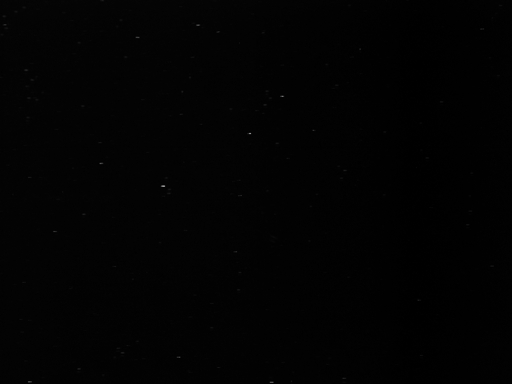

In [7]:
frames[0]

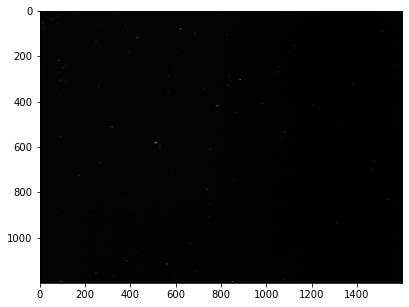

In [8]:
plt.imshow(frames[0])

In [9]:
frames[123].frame_no

123

In [10]:
frames[123].metadata

{}

## Image conversion
By default, `locate()` applies a bandpass and a percentile-based threshold to the image(s) before finding features. You can turn off this functionality using `preprocess=False, percentile=0.` In many cases, the default bandpass, which guesses good length scales from the `diameter` parameter, “just works.” But if you want to execute these steps manually, you can.

In [11]:
tp.find.percentile_threshold(frames[0],100)

4095.0

Frame([[65458, 65482, 65488, ..., 65483, 65491, 65479],
       [65476, 65467, 65469, ..., 65495, 65504, 65502],
       [65470, 65450, 65458, ..., 65482, 65491, 65483],
       ...,
       [65476, 65506, 65469, ..., 65503, 65501, 65535],
       [65487, 65507, 65462, ..., 65503, 65535, 65491],
       [65485, 65456, 65490, ..., 65515, 65483, 65490]], dtype=uint16)
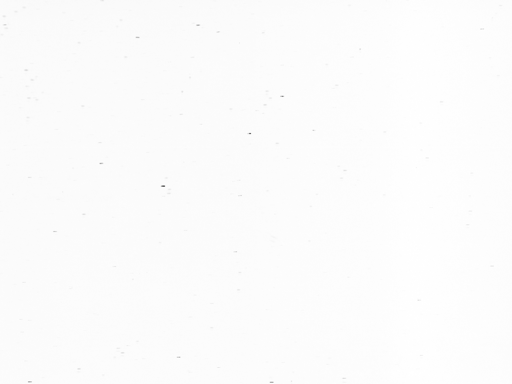

In [12]:
tp.preprocessing.invert_image(frames[0])

Frame([[77, 53, 47, ..., 52, 44, 56],
       [59, 68, 66, ..., 40, 31, 33],
       [65, 85, 77, ..., 53, 44, 52],
       ...,
       [59, 29, 66, ..., 32, 34,  0],
       [48, 28, 73, ..., 32,  0, 44],
       [50, 79, 45, ..., 20, 52, 45]], dtype=uint16)
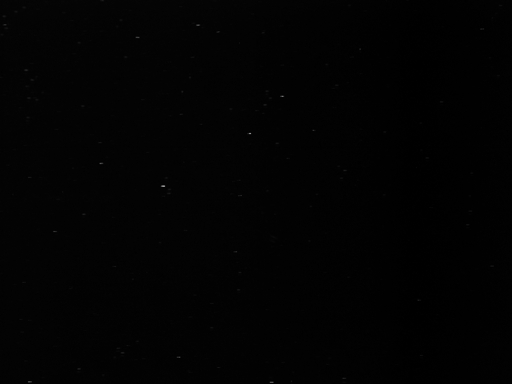

In [13]:
tp.preprocessing.convert_to_int(frames[0])[1]

## Locate features
Start with just the first frame. Estimate the size of the features (in pixels). The size must be an odd integer, and it is better to err on the large side, as we'll see below. We estimate 11 pixels.

The algorithm looks for bright features; since the features in this set of images are dark, we set `invert=True`.

`locate` returns a spreadsheet-like object called a DataFrame. It lists
- each feature's position,
- various characterizations of its appearance, which we will use to filter out spurious features,
- the "signal" strength and an estimate of uncertainty, both derived from this paper

More information about DataFrames may be found in the pandas documentation. DataFrames can easily be exported to formats like CSV, Excel, SQL, HDF5, etc.

In [14]:
i = 15
f = tp.locate(tp.preprocessing.convert_to_int(frames[i])[1], 15, invert=True, topn=50)
f

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
651,329.724455,249.159907,2335.759808,4.013930,0.115695,40.885322,9753801.0,-0.259913,15
201,104.184566,150.985610,2422.160590,4.029768,0.291395,47.155657,9749599.0,-0.141091,15
1837,910.743920,894.150807,2432.736442,3.738172,0.102637,57.646083,9752587.0,-0.209049,15
2077,1026.964233,665.425372,2480.857424,4.024305,0.360728,46.779779,9749882.0,-0.145573,15
668,335.523962,413.329105,2500.368931,3.874213,0.198165,56.116941,9750289.0,-0.152542,15
993,497.715188,710.096066,2514.353317,4.172524,0.469934,50.735045,9749289.0,-0.136487,15
892,449.768780,1030.029443,2518.991999,3.759586,0.310910,59.944067,9751611.0,-0.180630,15
1576,784.950811,275.526199,2563.021031,3.929908,0.455313,51.187808,9749558.0,-0.140464,15
1079,541.186531,161.284228,2567.967250,4.104286,0.474788,47.420481,9749056.0,-0.133221,15
1104,551.406466,1223.829796,2578.004912,4.113800,0.263598,46.933547,9756161.0,-0.493190,15


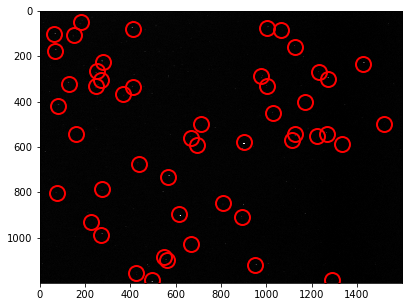

In [15]:
tp.annotate(f,frames[i])

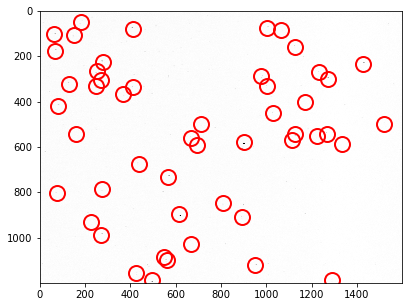

In [16]:
tp.annotate(f,tp.invert_image(frames[i]))

### **Refine parameters to elminate spurious features**

Many of these circles are clearly wrong; they are fleeting peaks in brightness that aren't actually particles. Rejecting them often improves results and speeds up feature-finding. There are many ways to distinguish real particles from spurious ones. The most important way is to look at total brightness ("mass").

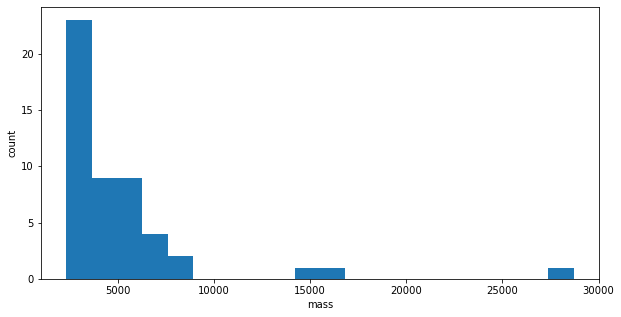

In [17]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

### **Check for subpixel accuracy**
As Eric Weeks points out in his related tutorial, a quick way to check for subpixel accuracy is to check that the decimal part of the x and/or y positions are evenly distributed. Trackpy provides a convenience plotting function for this called `subpx_bias`. 
If we use a mask size that is too small, the histogram often shows a dip in the middle.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C091221310>,
      dtype=object)

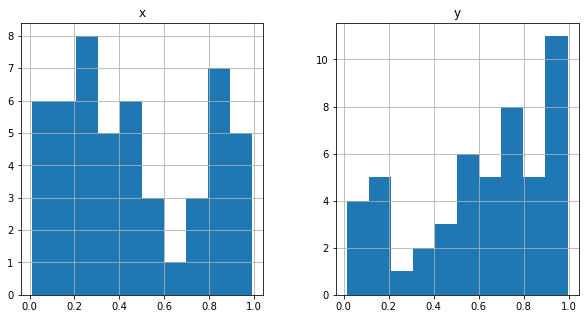

In [18]:
tp.subpx_bias(f)

###  **Locate features in all frames**
Or, to start, just explore a subset of the frames.

We'll locate features in the first 10 frames from this video. We use tp.batch, which calls tp.locate on each frame and collects the results.

As each frame is analyzed, `tp.batch` reports the frame number and how many features were found. If this number runs unexpectedly low or high, you may wish to interrupt it and try different parameters.

If your images are small, you may find that printing this number actually slows down batch significantly! In that case you can run `tp.quiet()` to turn it off.

In [19]:
f = tp.batch(frames[0:-1:1], 15, invert=True, topn=100)

Frame 437: 100 features


In [20]:
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,134.091849,752.988056,1069.603181,4.576741,0.434029,19.115579,9753981.0,-0.391914,0
1,1132.793039,82.853745,1076.413655,3.748852,0.341027,30.104844,9754477.0,-0.474425,0
2,871.126362,1088.119274,1080.074085,4.397246,0.450980,19.849260,9757172.0,3.296075,0
3,610.403996,995.117006,1102.507178,4.136665,0.344223,26.938851,9756323.0,-2.191997,0
4,230.911066,1559.838522,1127.340684,4.124334,0.443401,25.152498,9757066.0,4.794934,0


In [21]:
# np.save('z2',np.asarray(f))

## **Step 3: Link features into particle trajectories**
We have the locations of the particles in each frame. Next we'll track particles from frame to frame, giving each one a number for identification.

First, we must must specify a maximum displacement, the farthest a particle can travel between frames. We should choose the smallest reasonable value because a large value slows computation time considerably. In this case, 5 pixels is reasonable.

Second, we allow for the possibility that a particle might be missed for a few frames and then seen again. (Perhaps its "mass" slipped below our cutoff due to noise in the video.) Memory keeps track of disappeared particles and maintains their ID for up to some number of frames after their last appearance. Here we use 3 frames.

In [22]:
t = tp.link(f, 50, memory=10)

Frame 437: 100 trajectories present.


In [23]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,134.091849,752.988056,1069.603181,4.576741,0.434029,19.115579,9753981.0,-0.391914,0,0
72,156.723326,1129.957477,2823.236270,3.794651,0.125512,60.720075,9753037.0,-0.294449,0,1
71,299.862432,88.379087,2763.481145,4.059697,0.487314,62.035916,9748259.0,-0.130361,0,2
70,559.432550,92.837434,2747.619282,3.987145,0.424289,55.568359,9747078.0,-0.114578,0,3
69,299.686625,842.108377,2617.821548,3.946103,0.336592,52.458189,9753126.0,-0.301519,0,4


### **Filter spurious trajectories**
We have more filtering to do. Ephemeral trajectories — seen only for a few frames — are usually spurious and never useful. The convenience function `filter_stubs` keeps only trajectories that last for a given number of frames.

In [24]:
t1 = tp.filter_stubs(t, 50)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 2774
After: 181


We can also filter trajectories by their particles' appearance. At this stage, with trajectories linked, we can look at a feature's "average appearance" throughout its trajectory, giving a more accurate picture.

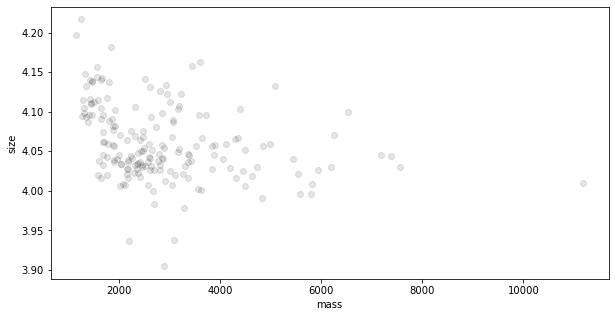

In [25]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

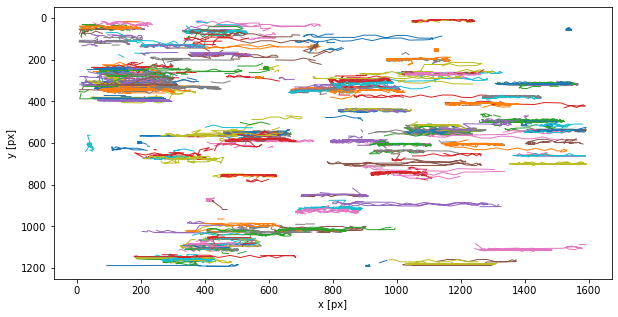

In [26]:
plt.figure()
tp.plot_traj(t1);

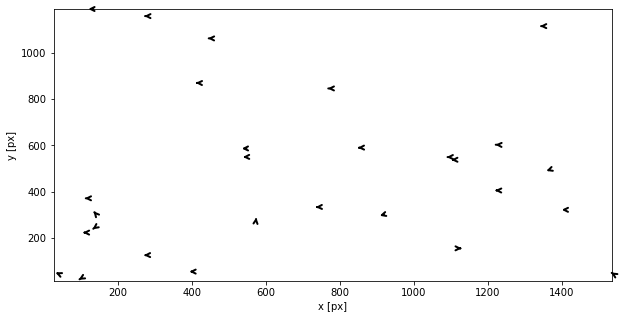

In [27]:
plt.figure()
tp.plot_displacements(t1,1,2);

In [28]:
t1

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,134.091849,752.988056,1069.603181,4.576741,0.434029,19.115579,9753981.0,-0.391914,0,0
0,156.723326,1129.957477,2823.236270,3.794651,0.125512,60.720075,9753037.0,-0.294449,0,1
0,44.421835,14.775771,2518.032962,4.011011,0.467828,56.621031,9745817.0,-0.101462,0,6
0,289.537935,574.509045,2476.324794,3.901181,0.262423,54.372140,9749850.0,-0.160062,0,9
0,322.816733,1382.989031,2176.823462,3.968073,0.528421,53.072248,9755935.0,-1.244792,0,13
...,...,...,...,...,...,...,...,...,...,...
437,605.193771,1056.871954,1058.541569,3.788077,0.296715,29.046400,9757562.0,-0.361001,437,1918
437,350.986394,257.700463,1609.189265,4.251847,0.442620,34.256857,9752871.0,-0.138347,437,762
437,386.981604,61.744562,1456.553855,4.217543,0.445196,27.110753,9752742.0,-0.136040,437,1990


# Interpretation of data

## Define fitting functions

In [29]:
def func(x, a, b, c, d, e):

    return a * np.cos( b * x + c) + d +e*x 


def func2(x, a, b, c):
    return a*np.cos(b*x + c)

## Show the raw data in the x-direction

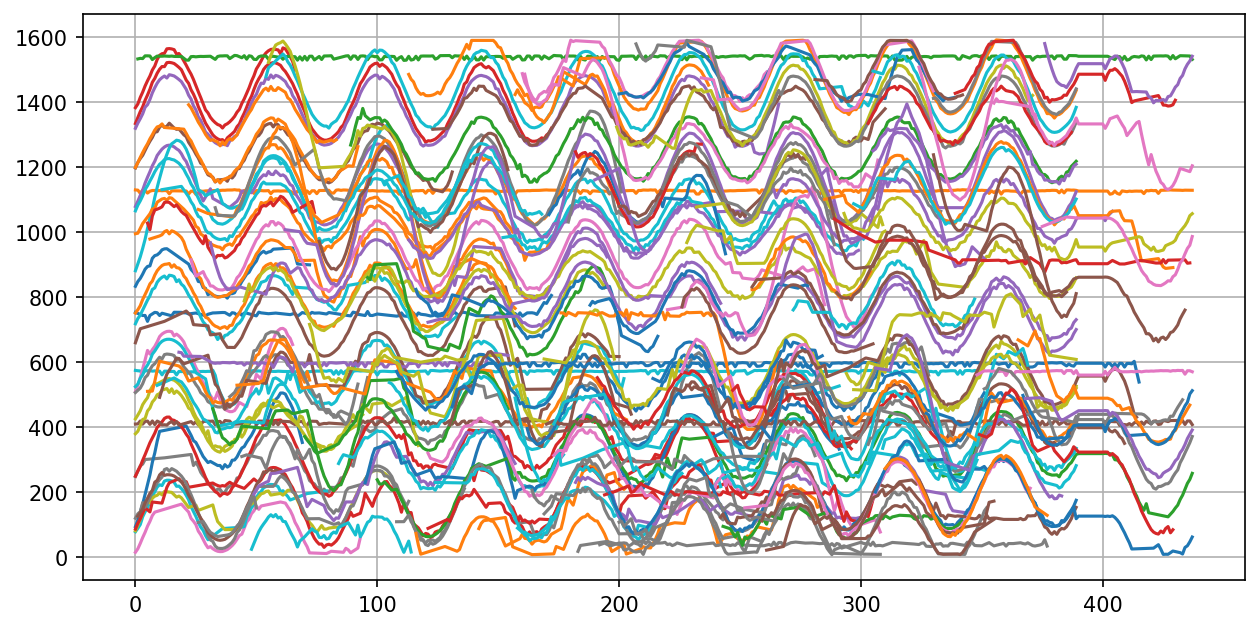

In [30]:
plt.figure(dpi=150)

N = max(t1['particle'])

for i in range(0,N,1):
    t2 = t1[t1['particle'] == i]
    
    #maxframe = np.max(t2.frame)
    #minframe = np.min(t2.frame)
    
    #if maxframe - minframe > 200:
    
    plt.plot(t2.frame,t2.x)
#     plt.plot(t2.frame,t2.y)

#     plt.plot(t2.frame,t2.x-np.mean(t2.x))
#     plt.plot(t2.frame,t2.y-np.mean(t2.y))

#xdum = np.linspace(0,430,1000)
#plt.plot(xdum,-70*np.sin(xdum*0.145+np.pi),'k--')

plt.grid()
plt.show()

## Fit and filter the function

[-1.20607355e+02  1.43557758e-01  1.08103290e+00  1.43878144e+03
  2.10910904e-01]
[-1.01997689e+02  1.46508795e-01  1.03856143e+00  1.12287672e+03
  3.76785223e-02]
[-1.00766240e+02  1.46056494e-01  1.06912746e+00  8.01317076e+02
  1.45457910e-02]
[-1.20856880e+02  1.45911862e-01  1.02972248e+00  1.40247317e+03
 -4.15148806e-02]
[-9.97995727e+01  1.67265597e-01  4.87904318e-01  2.09679818e+02
 -2.38657152e+00]
[-1.07470379e+02  1.44663810e-01  1.16330288e+00  1.48290492e+02
  2.49459763e-01]
[-9.85314499e+01  1.45263972e-01  1.16236729e+00  8.00657027e+02
 -9.53060292e-02]
[-1.19937019e+02  1.38737577e-01  2.49970503e+00  1.06527015e+03
  3.36079328e-01]
[-1.05549396e+02  1.45854321e-01  1.08500225e+00  1.51512858e+02
  1.35435949e-01]
[-1.20120754e+02  1.44853955e-01  1.29426307e+00  1.18012272e+03
 -1.04177173e-01]
[-1.14121407e+02  1.45771472e-01  1.10189689e+00  8.82096883e+02
  7.64575238e-02]
[-1.17876907e+02  1.44365688e-01  1.58296263e+00  1.47218002e+03
 -1.32570759e-01]
[-12

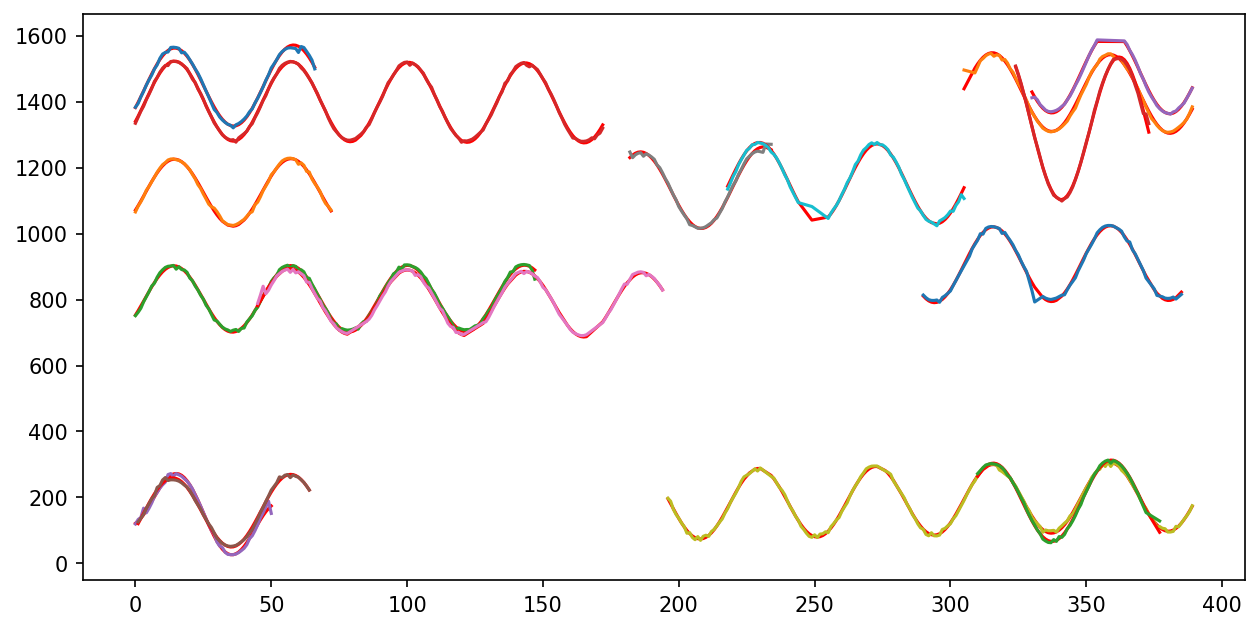

In [36]:
#max_frame_filter = 200
max_cof_filter = 200
error_ratio_filter = 0.99
min_amplitude = 0 #start at 0 and then change it to the majority


def rsquared(f,xdata,ydata,popt):
    residuals = ydata - f(xdata,*popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared


plt.figure(dpi=150)

N = max(t1['particle'])
#maxtotalframe = 0
#a_cof_total = 0
#a_err_array = np.zeros(N)

#a_array = np.zeros(N)
#y_array = np.zeros(N)


unique = np.unique(t1.particle.to_numpy())
N = len(unique)
a_cof = np.empty(0)
a_error = np.empty(0)
y_array = np.empty(0)

for i in unique:
    
    
    #i =22
    
    t2 = t1[t1['particle'] == i]
    
    
    if max(t2.x)-min(t2.x) <= max_cof_filter:
        continue
    
    #print(t2.frame)
    #maxframe = np.max(t2.frame)
    #minframe = np.min(t2.frame)
    
    #print(i)
    
    
    
    #if maxframe - minframe > max_frame_filter:
        #popt, _ = curve_fit(func, t2.frame, t2.x, )
        #print(type(t2.x))
        
        #print(t2.x)
    t3 = (t2.x).to_numpy()
    #print(t2)
    #print((t3))
    

    t_frame = (t2.frame).to_numpy()
    #print(t4)



    #x_new = detrend(t3)
    #y_new = detrend(t4)

    #print(max(x_new))
    #print(t_frame)
    #print(t2.x)
    #popt, _ = curve_fit(func, t2.frame, t2.x, p0 = (70, 0.1,0, 360, 0.025 ) )#bounds=((0, 0, -20, 0),(80, 0.5, 20, 1200)))
    popt, pcov = curve_fit(func, t_frame, t2.x, p0 = ((max(t2.x)-min(t2.x))/2, 0.15, 0, np.mean(t2.x),0))# bounds=((0, 0, -2*np.pi, -np.inf, -np.inf),(np.inf, np.inf, 2*np.pi, np.inf, np.inf)))
    
    



    
    b_cof = popt[1]
    c_cof = popt[2]

    perr = np.sqrt(np.diag(pcov))
    
  

    
    b_err = perr[1]
    c_err = perr[2]

    #print(a_cof)
    r2 = rsquared(func, t2.frame, t2.x, popt)
    #a_cof > max_cof_filter and
    if   r2 > error_ratio_filter:
        #print(r2)
        
        if abs(popt[0]) >= min_amplitude:
            a_err = perr[0]
            #print(perr[0])
            
            t4 = (t2.y).to_numpy()
            
            t4 = np.mean(t4)
            #print(t4)
            
            y_array = np.append(y_array,t4 )
            #y_array = np.append(y)

                          
            a_cof = np.append(a_cof,abs(popt[0]))
            a_error = np.append(a_error, abs(perr[0]))

            b_cof = popt[1]
            c_cof = popt[2]
            d_cof = popt[3]
            e_cof = popt[4]
            
            #print(d_cof)
            #print(e_cof)
            
            #print(a_cof)
            print(popt)
       
            plt.plot(t2.frame, func(t2.frame, *popt), 'r-')
        

            #a_array[i] = a_cof
            #y_array[i] = np.mean(t4)
            #a_err_array[i] = a_err
            #maxtotalframe = maxtotalframe + maxframe
            #print(maxtotalframe)
            #plt.plot(t_frame, x_new)
            plt.plot(t_frame, t2.x)
        #a_cof_total = a_cof_total + a_array[i]*maxframe
          

    #perr = np.sqrt(np.diag(pcov))

#print(perr)

#a_array = a_array[a_array != 0]
#a_err_array = a_err_array[a_err_array != 0]


#print(a_err_array)


#std = (np.sum(((a_array - np.mean(a_array))**2)/(len(a_array)-1)))
#print(a_cof_total/maxtotalframe)

#Z = np.mean(a_array)
#Y = np.std(a_array)

#print(Z)
#print(Y)

#print(a_cof)
#print(np.mean(a_cof))
#print(np.std(a_cof))
print(np.mean(a_cof))


## Obtain the data in pixel coordinates

In [37]:
print(np.mean(a_cof))
print(a_cof)

print(y_array)

error2 = np.sqrt(sum(a_error**2))

error1 = np.std(a_cof)

print(error1)
print(error2)
 
print(len(a_cof))



119.87462184008385
[120.60735532 101.99768868 100.76623969 120.85688023  99.79957265
 107.47037868  98.53144993 119.9370188  105.54939648 120.12075389
 114.12140692 117.87690721 121.05713921 224.88468188 124.54245805]
[319.28892523 552.30070049 849.52326    496.39654152 299.75080564
 260.56915401 912.9658719  267.51032877 345.36801898 540.79109888
 352.73506524 314.57649945 311.54706269 557.46749567 660.00659636]
29.42933596156906
4.8598682478113435
15


In [38]:
X = xconversion(a_cof,y_array)
X_mean = np.mean(X)


#X_err = xconversion(a_err_array, y_array)
#X_var = X_err**2
#X_er = np.sqrt(np.mean(X_var))
#print(X)
#print(X_err)
#print(X_var)
print('Amplitude = ', format( X_mean))
#
#print('Error = ', format(X_er))


fit_error = xconversion(a_error, y_array)


print('Error_fitting = ', format(np.sqrt(sum((fit_error**2)))))

print('Error = ', format(np.std(X)))

Amplitude =  0.014223016901084073
Error_fitting =  0.0010762143224256032
Error =  0.003456207690472811


In [39]:
print(frames)

<Frames>
Source: C:\Users\s131431\Documents\Thesis\Opnames\2021-03-08\curvelength700stroke45\curvelength700stroke45\z = 2\*.tiff
Length: 439 frames
Frame Shape: (1200, 1600)
Pixel Datatype: uint16
